In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from numpy.polynomial.polynomial import polyfit

%matplotlib inline

# Data Overview

This dataset provides powerlifting competition information from meets from all powerlifting associations from 1974 to 2018. I chose this dataset because I have friends that often participate in powerlifting competitions. The database was accessed from Kaggle and was last updated January 2018. The main metrics we will be looking at are the competiton best lifts and the total lifts in Kg. This dataset provides over 300,000 entries that will help to identify any trends that exist between genders, ages, and various equipments. By analyzing this data, I hope to gain insight on how different variables affect overall scores.

The dataset includes MeetID, name, sex, equipment, age, division, bodyweight, weightclass, 4kg(Squat, Bench, Deadlift), Best (Squat, Bench, Deadlift), TotalKg, Place, and Wilks score.

The MeetID column is unique to each hosted event. Equipment ranges from raw (no equipment), wraps, single-ply, and multiply jumpers. Divisions are seperated by a multitude of factors such as age, equipment, and skill level. Competitors will compete within their weightclass. The BestSquatKg, BestBenchKg, and BestDeadliftKg are the best successful lifts that are recorded and added up to give the TotalKg score which is used to score competitors in the Place column. The Wilk's score, which is a measure of strength taking into account age weight and gender, is also given. I'm are not sure what the 3 columns Squat4kg, Bench4kg, and Deadlift4kg refer to. These columns do not appear to provide valuable information on performance, and will be dropped due to their inconsistent and incomplete nature.

There are many challenges working with this dataset. For one, there are many different divisions and abbreviations that appear to be exclusive to the association hosting the event. In addition, there are many negative entries that are unexplained. Finally, not all events measure the same metric. In some events, competitors only perform 1 or 2 of the 3 lifts which may throw off TotalKg.

I am mainly interested in the TotalKg score as it represents a participants overall performance. What impact does Gender have on TotalKg score? Age? What relationship does the Wilk's score have with TotalKg score?

In [2]:
raw_input = pd.read_csv('file:///C:/Users/JChaotogo/Desktop/New%20folder/89c19c54077b818ea69d314e74bb6fbf-27aba85593a688b47ec141d0d6e7f60a9e9d33a9/openpowerlifting.csv')
raw_input.head()

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,Angie Belk Terry,F,Wraps,47.0,Mst 45-49,59.60,60,NaN,47.63,NaN,20.41,NaN,70.31,138.35,1,155.05
1,0,Dawn Bogart,F,Single-ply,42.0,Mst 40-44,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
2,0,Dawn Bogart,F,Single-ply,42.0,Open Senior,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
3,0,Dawn Bogart,F,Raw,42.0,Open Senior,58.51,60,NaN,NaN,NaN,95.25,NaN,NaN,95.25,1,108.29
4,0,Destiny Dula,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,NaN,NaN,31.75,NaN,90.72,122.47,1,130.47


From the data above, I notice some negative values and disqualifications that may throw off our analysis. Here I remove any negative entries and drop the 4kg columns to help clean up the data.

# Data Cleaning

In [3]:
#Remove Disqualifications and Inconsistent columns
df = raw_input.drop(['Bench4Kg', 'Squat4Kg', 'Deadlift4Kg'], axis = 1)
df = df[(df.Place!='DQ')&(df.BestSquatKg>=0)&(df.BestBenchKg>=0)&(df.BestDeadliftKg>=0)&(df.TotalKg>0)]
dfdropped = raw_input[(raw_input.Place=='DQ')|(raw_input.BestSquatKg<0)|(raw_input.BestBenchKg<0)|(raw_input.BestDeadliftKg<0)|(raw_input.TotalKg<0)]

print(dfdropped.shape[0]/df.shape[0])
dfdropped.info()

0.08032482144604246
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22988 entries, 25 to 386394
Data columns (total 17 columns):
MeetID            22988 non-null int64
Name              22988 non-null object
Sex               22988 non-null object
Equipment         22988 non-null object
Age               7753 non-null float64
Division          21924 non-null object
BodyweightKg      21650 non-null float64
WeightClassKg     21618 non-null object
Squat4Kg          17 non-null float64
BestSquatKg       9856 non-null float64
Bench4Kg          22 non-null float64
BestBenchKg       7593 non-null float64
Deadlift4Kg       14 non-null float64
BestDeadliftKg    5711 non-null float64
TotalKg           7 non-null float64
Place             22988 non-null object
Wilks             6 non-null float64
dtypes: float64(10), int64(1), object(6)
memory usage: 2.6+ MB


22988 Rows (8.03%) were discarded due to disqualifications or negative entries that would throw off analysis of the entire sample. Next I seperate out the different divisions that participants compete in. This dataset includes multiple associations that have the same divisions but with slightly different entries such as 'Open' vs 'O'; I can combine these divisions because they have similar requirements for competitors.


In [4]:
df['TotalKg'].sort_values(ascending=False).head()

57011     1365.31
53198     1363.05
162480    1360.78
55694     1344.90
163054    1342.63
Name: TotalKg, dtype: float64

In [5]:
maledf = df[df['Sex'] == 'M']
femaledf = df[df['Sex'] == 'F']
dfage = df[df.Age.notnull()]

# Gender and Total Kg Relationship
Here I look at the percentage of competitors of each sex and compare their individual Total Kg scores.

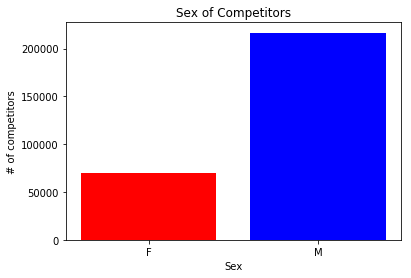

Percentage of Male competitors is 75.69429885250256 %
Percentage of Female competitors is 24.305701147497448 %


In [6]:
gendercount = df.groupby(['Sex'])['MeetID'].count().reset_index()
F, M = plt.bar(gendercount['Sex'], gendercount['MeetID'])
plt.xlabel('Sex')
plt.ylabel('# of competitors')
plt.title('Sex of Competitors')
F.set_facecolor('r')
M.set_facecolor('b')
plt.show()
print('Percentage of Male competitors is', maledf.Sex.shape[0]/df.shape[0]*100, '%')
print('Percentage of Female competitors is', femaledf.Sex.shape[0]/df.shape[0]*100, '%')

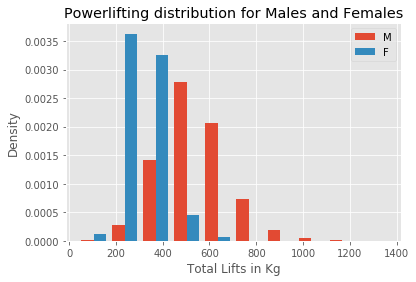

In [7]:
plt.style.use('ggplot')
plt.hist([maledf['TotalKg'], femaledf['TotalKg']], density=True)
plt.legend(['M', 'F'])
plt.xlabel('Total Lifts in Kg')
plt.title('Powerlifting distribution for Males and Females')
plt.ylabel('Density')
plt.show()

In [8]:
print('Total Kg Variance for Males:', np.var(maledf.TotalKg))
print('Total Kg Variance for Females:', np.var(femaledf.TotalKg))
print(ttest_ind(maledf.TotalKg, femaledf.TotalKg))
df[['Sex', 'TotalKg']].groupby('Sex').describe().transpose()


Total Kg Variance for Males: 21067.03481510059
Total Kg Variance for Females: 6362.646455132493
Ttest_indResult(statistic=399.6254726795027, pvalue=0.0)


Sex                       F              M
TotalKg count  69560.000000  216628.000000
        mean     313.400588     543.744019
        std       79.766772     145.145210
        min       40.800000      38.600000
        25%      260.000000     446.790000
        50%      305.000000     537.500000
        75%      355.000000     630.490000
        max      816.470000    1365.310000

Of the data collected, 24.3% of the entries were reported as female and 75.7% were men. Male competitors had a much higher TotalKg score with a mean value of 544kg vs 313kg for females. However, the variance and standard deviation in TotalKg scores for males was much higher.

The t-test indicates that there is significant difference between the populations and the p-value of 0 indicates that this analysis is repeatable and there is zero chance the data is random. 

# Age Comparison
This dataset includes lifts from competetitors ranging from 7 years old to 93 years old. Unfortunately, not all the ages are given, possibly due to the particular competition not asking for an age.

What is the age distribution like?

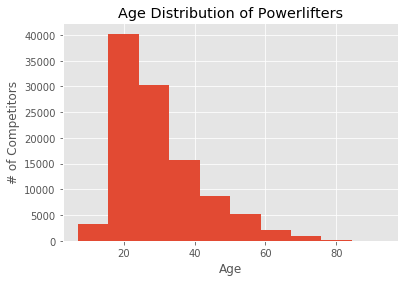

count    106743.000000
mean         29.870137
std          11.751413
min           7.000000
25%          21.500000
50%          26.500000
75%          35.500000
max          93.000000
Name: Age, dtype: float64

In [9]:
#Age distribution plot
plt.style.use('ggplot')
plt.hist(dfage.Age)
plt.xlabel('Age')
plt.ylabel('# of Competitors')
plt.title('Age Distribution of Powerlifters')
plt.show()
display(df['Age'].describe())

Of the entries where age is given, the majority of competitors are in their 20s and 30s. Due to this, taking the mean age of 29.87 with a standard deviation of 11.75 years best describes the central tendency. As age increases past 20, the number of competitors decreases. There are competitors of extreme ages on both sides of the spectrum with the youngest being 7 years old and the oldest being 93 years old. 

Below I look at the TotalKg distributions of each 10 year age range.

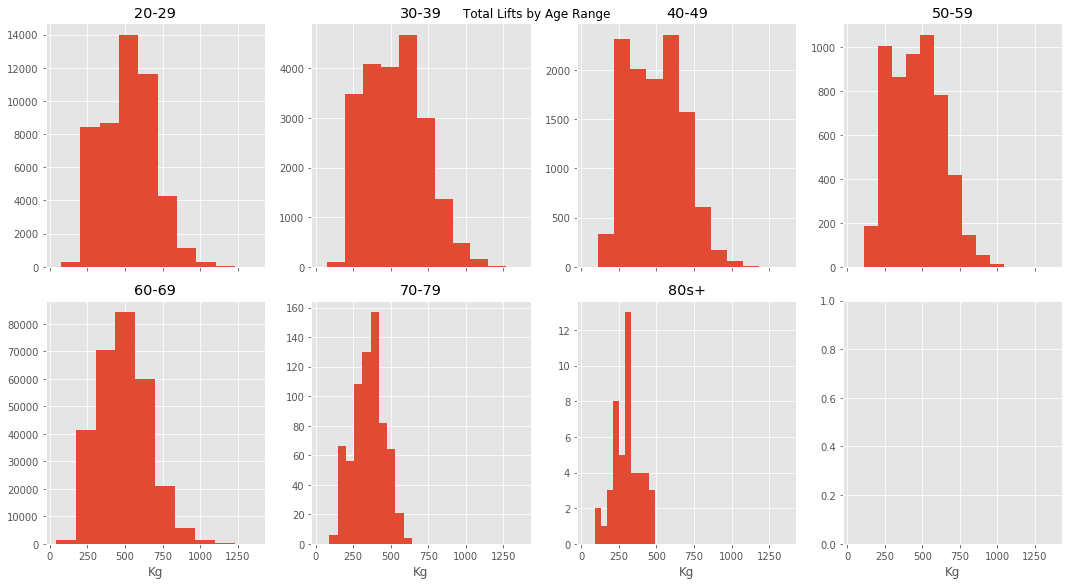

In [10]:
twenties = df[(df.Age>= 20)&(df.Age<30)]
thirties = df[(df.Age>=30)&(df.Age<40)]
fourties = df[(df.Age>=40)&(df.Age<50)]
fifties = df[(df.Age>=50)&(df.Age<60)]
sixties = df[(df.Age>=60)&(df.Age)<70]
seventies = df[(df.Age>=70)&(df.Age<80)]
eightiesup = df[df.Age>=80]

fig, ((plt1, plt2, plt3, plt4), (plt5, plt6, plt7, plt8)) = plt.subplots(2,4, figsize=(15,8), sharex=True)
plt1.hist(twenties['TotalKg'])
plt1.set_title('20-29')
plt2.hist(thirties['TotalKg'])
plt2.set_title('30-39')
plt3.hist(fourties['TotalKg'])
plt3.set_title('40-49')
plt4.hist(fifties['TotalKg'])
plt4.set_title('50-59')
plt5.hist(sixties['TotalKg'])
plt5.set_title('60-69')
plt6.hist(seventies['TotalKg'])
plt6.set_title('70-79')
plt7.hist(eightiesup['TotalKg'])
plt7.set_title('80s+')
fig.suptitle('Total Lifts by Age Range')
plt.tight_layout()
plt5.set_xlabel('Kg')
plt6.set_xlabel('Kg')
plt7.set_xlabel('Kg')
plt8.set_xlabel('Kg')
plt.show()

The distribution of competitors in their 20s and 30s looks similar. We can further test to see if there is a significant difference in the 2 age groups.
Now that we have the distribution of total lifts in kg, how do the TotalKg scores of competitors in their 20s and 30s compare?

Ttest_indResult(statistic=6.0124372237181705, pvalue=1.8365468948331622e-09)


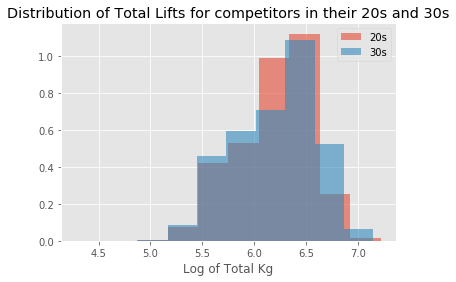

In [11]:
np.log(df[(df.Age >=20)&(df.Age <30)]['TotalKg']).hist(density=True, alpha=.6)
np.log(df[(df.Age >=30)&(df.Age <40)]['TotalKg']).hist(density=True, alpha=.6)
plt.legend(['20s', '30s'])
plt.title('Distribution of Total Lifts for competitors in their 20s and 30s')
plt.xlabel('Log of Total Kg')
print(ttest_ind(thirties.TotalKg, twenties.TotalKg , equal_var=True))

In [12]:
ttest_1samp(twenties.TotalKg, df.TotalKg.mean())
#people in their 20s lift an average of 42 st errors more than the population mean

Ttest_1sampResult(statistic=42.472405476751796, pvalue=0.0)

In [13]:
twenties.describe()

,MeetID,Age,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Wilks
count,48703.000000,48703.000000,48694.000000,48703.000000,48703.000000,48703.000000,48703.000000,48694.000000
mean,6127.174815,24.209638,84.816536,187.734247,121.492388,211.350771,520.576585,375.501240
std,2599.328046,2.743890,21.836246,66.351843,49.152374,60.683058,170.529043,72.755006
min,0.000000,20.000000,33.660000,15.900000,18.100000,25.000000,72.600000,59.440000
25%,4825.000000,22.000000,69.100000,137.500000,80.000000,160.000000,380.000000,326.787500
50%,7187.000000,24.000000,81.900000,185.000000,122.500000,217.500000,530.000000,370.970000
75%,7979.000000,26.500000,97.800000,227.500000,152.500000,255.000000,637.300000,417.480000
max,8464.000000,29.500000,230.800000,548.850000,442.250000,440.000000,1363.050000,779.380000


In [14]:
thirties.describe()

,MeetID,Age,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Wilks
count,21409.000000,21409.000000,21398.000000,21409.000000,21409.000000,21409.000000,21409.000000,21398.000000
mean,5963.568079,34.058947,89.938554,191.169560,127.247293,210.936619,529.352274,377.682884
std,2755.147098,2.861280,24.756851,76.882981,57.756713,65.816434,193.915141,84.963396
min,0.000000,30.000000,30.100000,25.000000,17.500000,25.000000,75.000000,48.560000
25%,4752.000000,31.500000,71.800000,127.500000,75.000000,152.500000,357.500000,318.560000
50%,7246.000000,34.000000,88.100000,185.000000,125.000000,215.000000,530.000000,370.310000
75%,8004.000000,36.500000,105.800000,240.000000,165.000000,260.000000,665.000000,429.227500
max,8464.000000,39.500000,242.400000,508.020000,396.890000,412.500000,1270.060000,756.760000


In [15]:
print(ttest_ind(thirties.TotalKg, twenties.TotalKg , equal_var=False))
print('20s Variance =', np.var(twenties.TotalKg))
print('30s Variance =', np.var(thirties.TotalKg))

Ttest_indResult(statistic=5.720362374543261, pvalue=1.0712467993617458e-08)
20s Variance = 29079.557433644502
30s Variance = 37601.32550745787


When comparing the lifts of competitors in their 20s and 30s, we get a t-statistic of 5.72 with a p-value approaching 0. From these results, we can fairly certainly conclude that competitors in their 30s lift more than competitors in their 30s on average. Although competitors in their 30s lift more than those in their 20s, the variance for TotalKg scores is significantly higher.

We can also take the mean TotalKg score per year to determine if there is a trend between age and TotalKg.

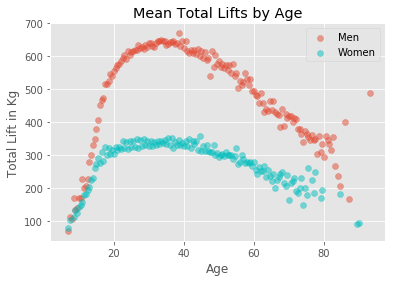

In [16]:
ageliftm = maledf.groupby('Age', as_index=False).agg(np.mean)
ageliftf = femaledf.groupby('Age', as_index=False).agg(np.mean)

plt.scatter(x=ageliftm.Age, y=ageliftm.TotalKg, alpha=.5, label='Men')
plt.scatter(x=ageliftf.Age, y=ageliftf.TotalKg, alpha=.5, color='c', label='Women')
plt.xlabel('Age')
plt.ylabel('Total Lift in Kg')
plt.legend(loc='upper right')
plt.title('Mean Total Lifts by Age')
plt.show()

The chart above shows the mean total lifts of men and women by age. Male competitors on average have peak lifts from ages 25-40. Lifters older than 40 have a sharp decline in their total lifts. Female competitors on average have peak lifts from ages 20-40. Older lifters' total lifts drop off after age 40 but at a much more level rate.

# Does Equipment have an Effect on Total Kg Scores?
Another interesting column is the one for equipment. There are 4 different entries for equipment that may significantly affect performance. What is the percentage of participants using each type of equipment?

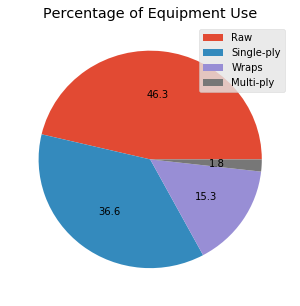

In [17]:
Equipcount = pd.DataFrame(df.Equipment.value_counts())
plt.figure(figsize=(5,5))
plt.pie(Equipcount.Equipment, autopct='%.1f')
plt.legend(Equipcount.index)
plt.title('Percentage of Equipment Use')
plt.show()

The above pie chart shows the percentage of equipment use. Most competitors are categorized as 'Raw' meaning they don't use any equipment. What effect on TotalKg score does Equipment have?

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


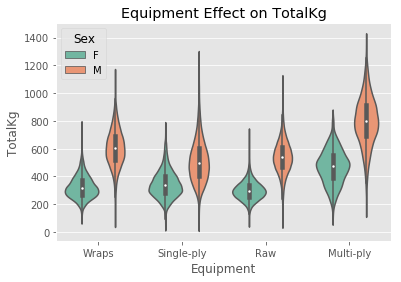

In [18]:
violinplot = sns.violinplot(x='Equipment', y='TotalKg', hue='Sex', data=df, palette='Set2')
plt.title('Equipment Effect on TotalKg')
plt.show()

The violin plot shows the range of values for each equipment entry seperated by sex.

The graphs for raw and wraps look to be quite similar for both genders. 

In [19]:
print('Female Raw:Wraps t-test ', ttest_ind(femaledf[femaledf.Equipment == 'Raw']['TotalKg'], femaledf[femaledf.Equipment =='Wraps']['TotalKg']))
print('Male   Raw:Wraps t-test ', ttest_ind(maledf[maledf.Equipment == 'Raw']['TotalKg'], maledf[maledf.Equipment == 'Wraps']['TotalKg']))

Female Raw:Wraps t-test  Ttest_indResult(statistic=-33.99098372682473, pvalue=1.0952161050225717e-250)
Male   Raw:Wraps t-test  Ttest_indResult(statistic=-82.69131250531264, pvalue=0.0)


For both male and female competitors, multi-ply equipment has the largest impact for all lifts. Female raw competitors on average have the lowest lift numbers. The density near the mean in the violin plot shows that the female TotalKg scores have a much lower variance.

Although the plot for raw and wraps look similar for both genders, the t-values of -33 and -83 with a corresponding p-values approaching zero for women and men respectively show that the using wraps results in significantly increased TotalKg numbers on average.

Surprisringly for men, competitors using single-ply equipment had lower lifts in all categories except for Best Squat Kg. A future project asking competitors asking competitors why they choose their equipment can help to explain this. The variance is also much greater for men than women in all equipment.

# Relationship Between Wilk's Score and Total Kg.

C:\Users\JChaotogo\AppData\Local\Programs\Python\Python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


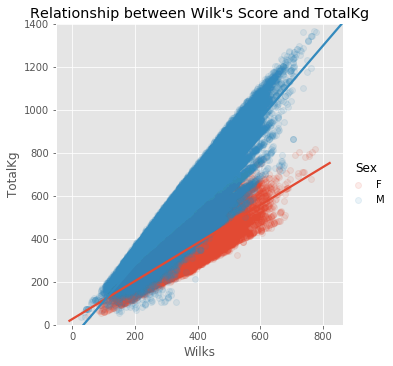

In [20]:
#Scatter plot of relationship between Wilks and TotalKg seperated by sex.
g=sns.lmplot(x='Wilks', y='TotalKg', data=df, hue='Sex', scatter=True, scatter_kws={'alpha':0.1})
plt.title("Relationship between Wilk's Score and TotalKg")
plt.ylim(0, 1400)
plt.show()

In [21]:
wilksm = maledf.groupby('Wilks', as_index=False).agg(np.mean)
wilksf = femaledf.groupby('Wilks', as_index=False).agg(np.mean)
print(ttest_ind(wilksm.TotalKg, wilksf.TotalKg))

Ttest_indResult(statistic=193.9554637464175, pvalue=0.0)


The Wilk's score is a measure of a powerlifter's strength taking into account weight, age, and gender. Above, I took the mean TotalKg for each corresponding Wilk's score. As expected, we get a positive linear relationship between a competitor's Wilk's score and the competitors total lifts. 

Surprisingly however, the slopes of TotalKg/Wilks for men is significantly higher than for women. Wilk's score is supposed to take into account gender, and ideally the TotalKg/Wilks ratio should be equal between men and women. It looks like there is a systematic error in calculating Wilk's score. One possible explanation could be that the scores were self-reported, with men over-reporting their numbers.

# Conclusion
Overall we analyzed the effect that gender, age, equipment, and Wilk's score has on the TotalKg competition scores. From our analysis, we found that men have significantly higher scores than women but also a much higher variance between competitors. In addition, TotalKg scores were highest in those aged 20-40 and sharply declined 40+. In our equipment analysis, we found that multi-ply equipment had an enormous effect on TotalKg scores. Surprisingly however, single-ply equipment often scored lower than raw (no equipment) for men. Our analysis of Wilk's score was also interesting. As expected, TotalKg scores increased linearly with Wilk's score, but not at the same rate between genders.


# Future Work
1. Originally, I was going to group divisions together to compare with each other, but there are many similar divisions for each different association. For a future study, we could seperate out the associations do a comparison on how each corresponding division does within each association.
2. Analysis of the effect that equipment had on performance came out with surprising results. Competitors using single-ply equipment should have performed better on average than those competing raw. Our results show the opposite. To explain this phenomenom, we could run a seperate project that surveys competitors on their opinion of the availible equipment.
3. This data set includes data from competitors from 1974 to 2018. We could further analyze if strength of participants changes on average over time.